### Prueba técnica - Itinerario Data Science con python

# Notebook 1. Obtención de los datos y creación de una base de datos MySQL. 



## 1. Web scraping.

Voy a utilizar los datos que tiene disponibles https://datosclima.es en su página. 

In [1]:
## Librerías

# Data wrangling
#-----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Web scraping
#-----------------------------------------------------------------------
import requests 
from selenium import webdriver
from selenium.webdriver import Firefox
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.firefox.options import Options

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.support.ui import Select

# Varios
#-----------------------------------------------------------------------
import time


# MySQL conection
#-----------------------------------------------------------------------
import mysql.connector


En https://datosclima.es se pueden descargar series históricas de datos registrados por 291 estaciones metereológicas. Para obtener los históricos de cada parámetro (temperatura, presión, precipitaciones...) es necesario acceder a una página diferente y rellenar un formulario web. 


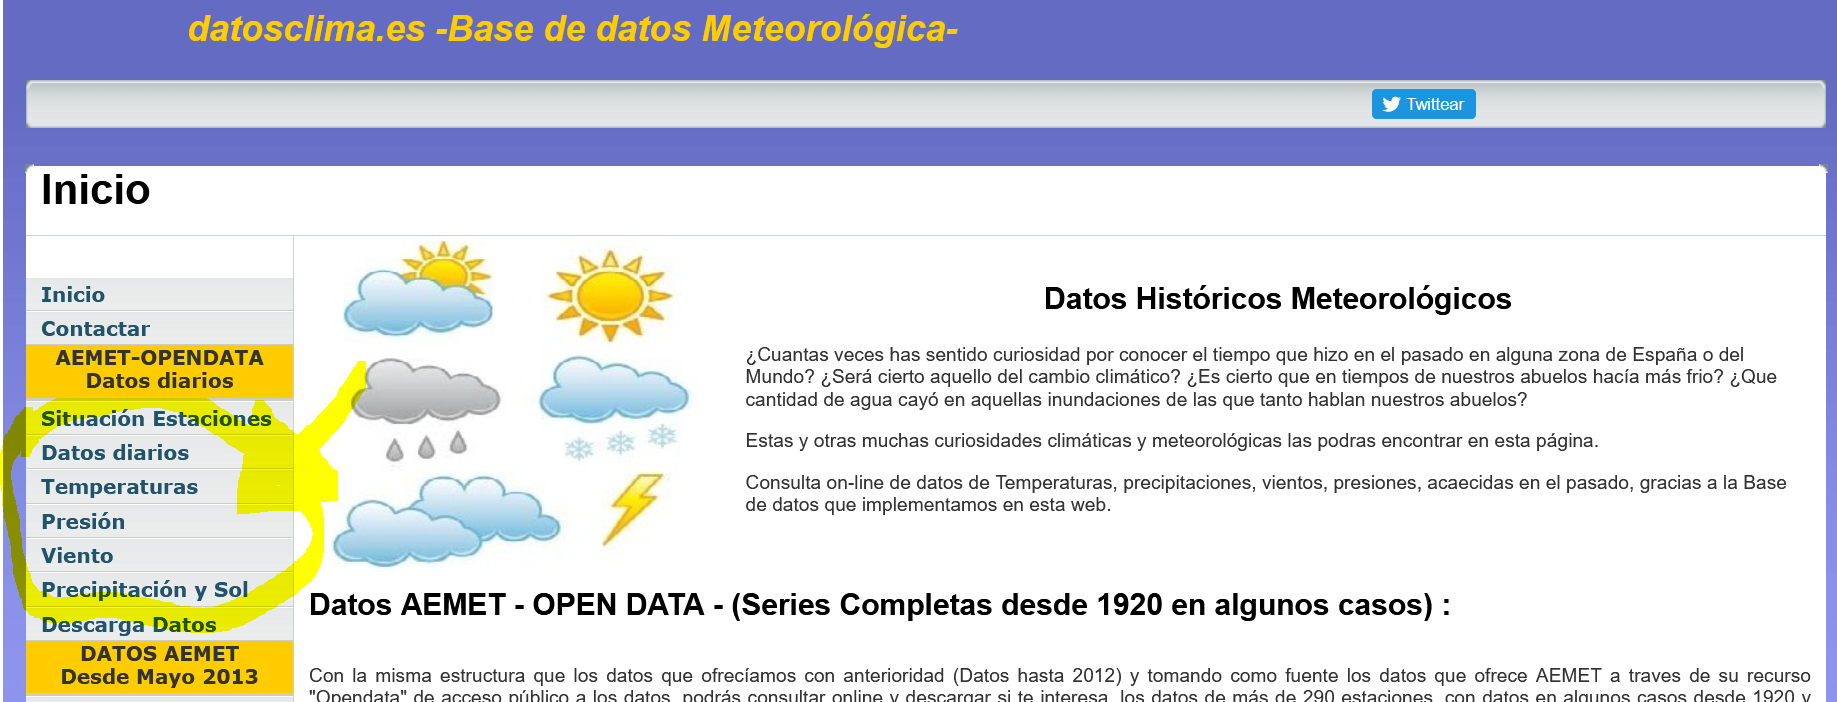

La respuesta de este formulario es un conjunto de tablas anidadas en grupos de tres. 

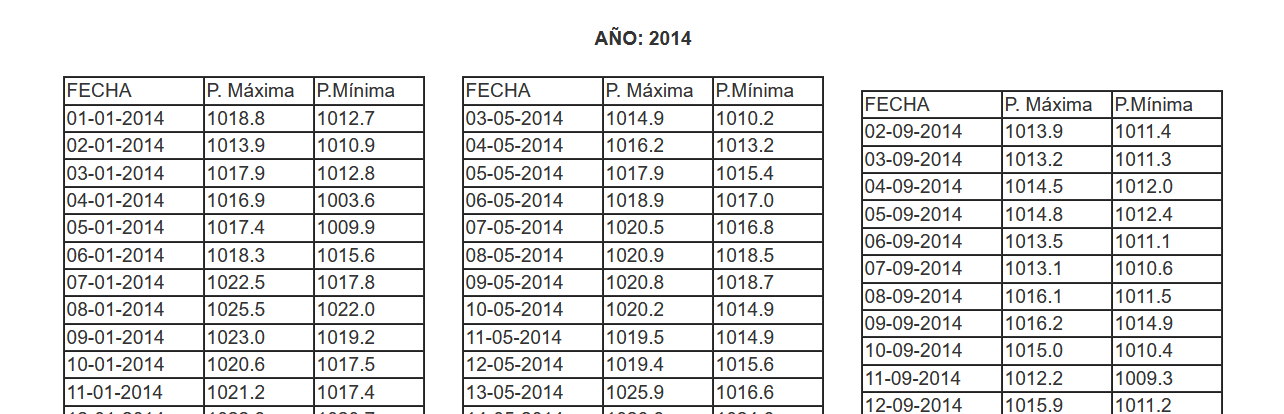

Para obtener la información voy a crear una función donde introduciré la variable que quiero descargar, temperatura, presión, el nombre de la provincia y la estación y las fechas de inicio. Esta función me devolverá un dataframe con los datos históricos que hemos pedido.



In [2]:
def obtener_datosclima(tag, provincia, estacion, inicio, fin):
    
    ''' Esta función descarga los datos metereológicos de datosclima.es y devuelve un dataframe.
            Args: 
                tag: Variabla que descarga, a escoger entre "Temperaturas", "Presión", "Viento", 
                "Precipitación y Sol"
                provincia: Provincia en mayúsculas
                estación: Nombre de la estación metereológica
                inicio: Fecha de inicio en formato DD/MM/YYYY
                fin: Fecha final en formato DD/MM/YYYY
            
            Return: Tabla datos'''
    
    
    # setting url
    URL = 'https://datosclima.es/'
    # Setting browser options
    opciones=Options()
    opciones.load_strategy='normal'
    # Instantiate browser
    navegador=Firefox(options=opciones)
    # Opening URL
    navegador.get(URL)
    
    navegador.implicitly_wait(30)
    
    #Navigate
    menus = navegador.find_elements_by_link_text(tag)
    menus[0].click()
    
    time.sleep(3)
    # Selecting Provincia - Barcelona
    #PROV = navegador.find_element_by_name('Provincia')
    #PROV.send_keys(provincia)
    PROV = Select(navegador.find_element_by_name('Provincia'))
    PROV.select_by_value('BARCELONA')
    
    time.sleep(3)
    # Selecting Meteo_Station - Barcelona
    #EST = navegador.find_element_by_name('id_hija')
    #EST.send_keys(estacion)
    EST = Select(navegador.find_element_by_name('id_hija'))
    EST.select_by_visible_text('BARCELONA AEROPUERTO')
    
     # Setting initial date
    navegador.find_element_by_name('Iday').send_keys((inicio.split("/")[0]))
    navegador.find_element_by_name('Imonth').send_keys(inicio.split('/')[1])
    navegador.find_element_by_name('Iyear').send_keys(inicio.split('/')[2])
        
    # Setting final date
    navegador.find_element_by_name('Fday').send_keys(fin.split('/')[0])
    navegador.find_element_by_name('Fmonth').send_keys(fin.split('/')[1])
    navegador.find_element_by_name('Fyear').send_keys(fin.split('/')[2])
    
    # Button
    time.sleep(3)
    navegador.find_element_by_css_selector('div.feature > div:nth-child(2) > \
                                        form:nth-child(1) > input:nth-child(12)').click()

    
    time.sleep(60)
    ##Tables
    # Find table
    lista_tablas = navegador.find_elements_by_tag_name('table')[2:]
    
   # lista_tablas = WebDriverWait(navegador, 
   #                                  30).until(EC.visibility_of_all_elements_located((By.TAG_NAME, 'table')))[2:]
        
    historico = []

    for numero in range(len(lista_tablas)):
        if numero in range(0,len(lista_tablas),4):
            print(numero)
        else:
            tabla = []
            rows = lista_tablas[numero].find_elements_by_tag_name('tr')
            for row in rows:
                columns = row.find_elements_by_tag_name('td')
                fila = [td.text for td in columns]
                tabla.append(fila)
        
            historico.extend(tabla)
            
    historico_data = pd.DataFrame(historico[1:],columns=historico[0]).drop_duplicates(keep=False)
            
    navegador.close()
    
    return historico_data

In [3]:
precipitaciones =obtener_datosclima(tag ='Precipitación y Sol',
                                    provincia='BARCELONA',
                                    estacion='BARCELONA AEROPUERTO',
                                    inicio='01/01/1992',
                                    fin='01/07/2021')

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116


In [4]:
temperaturas = obtener_datosclima(tag ='Temperaturas',
                                    provincia='BARCELONA',
                                    estacion='BARCELONA AEROPUERTO',
                                    inicio='01/01/1992',
                                    fin='01/07/2021')

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116


In [5]:
presion = obtener_datosclima(tag ='Presión',
                             provincia='BARCELONA',
                             estacion='BARCELONA AEROPUERTO',
                             inicio='01/01/1992',
                             fin='01/07/2021')

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116


In [6]:
viento = obtener_datosclima(tag ='Viento',
                            provincia='BARCELONA',
                            estacion='BARCELONA AEROPUERTO',
                            inicio='01/01/1992',
                            fin='01/07/2021')

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116


## 1.1. Preparación del dataframe para ingestar.

Tenemos cuatro dataframes resultantes con datos desde 1992 hasta 2021 de temperaturas, presiones, precipitaciones, horas de sol y velocidad media del viento. Veamos las primeras filas. 

In [7]:
viento.head(3)

,FECHA,Racha Max (Km/h),Hora Racha,Veloc. Media (Km/h)
0,01-01-1992,36,04:50,7.92
1,02-01-1992,21.96,15:15,11.16
2,03-01-1992,29.16,03:40,7.92


In [8]:
temperaturas.head(3)

,FECHA,T. Máxima,T.Mínima
0,01-01-1992,11.6,0.3
1,02-01-1992,12.6,0.2
2,03-01-1992,12.2,2.3


In [9]:
presion.head(3)

,FECHA,P. Máxima,P.Mínima
0,01-01-1992,1037.8,1033.6
1,02-01-1992,1038.6,1037.0
2,03-01-1992,1037.3,1032.7


In [10]:
precipitaciones.head(3)

,FECHA,Precipitación: l/m2,Horas Sol:
0,01-01-1992,0.0,6.6
1,02-01-1992,0.0,6.4
2,03-01-1992,0.3,1.0


Vamos a unirlos en un dataframe, descartaremos las variables "Hora Racha" y "Racha Max" y preprocesaremos los datos antes de ingestarlos en una base de datos relacional en MySQL.

In [22]:
DATA = precipitaciones.merge(presion,on='FECHA').merge(temperaturas, on='FECHA').merge(viento, on='FECHA')
DATA

,FECHA,Precipitación: l/m2,Horas Sol:,P. Máxima,P.Mínima,T. Máxima,T.Mínima,Racha Max (Km/h),Hora Racha,Veloc. Media (Km/h)
0,01-01-1992,0.0,6.6,1037.8,1033.6,11.6,0.3,36,04:50,7.92
1,02-01-1992,0.0,6.4,1038.6,1037.0,12.6,0.2,21.96,15:15,11.16
2,03-01-1992,0.3,1.0,1037.3,1032.7,12.2,2.3,29.16,03:40,7.92
3,04-01-1992,0.0,5.7,1034.3,1031.4,12.5,1.3,24.84,09:15,11.16
4,05-01-1992,0.0,6.8,1034.3,1032.0,12.4,0.2,21.96,Varias,11.16
...,...,...,...,...,...,...,...,...,...,...
10770,27-06-2021,0.0,11.0,1014.7,1012.0,27.0,21.0,28.08,Varias,12.96
10771,28-06-2021,0.0,9.8,1015.5,1011.4,27.2,20.1,33.12,00:40,12.96
10772,29-06-2021,0.0,8.2,1017.8,1014.8,26.3,21.8,34.92,14:00,15.12
10773,30-06-2021,0.0,9.0,1018.1,1016.0,26.5,23.0,33.12,14:56,18


In [23]:
# New column ID
DATA.reset_index(inplace=True)

In [24]:
# Droping useless features
DATA.drop(columns=['Racha Max (Km/h)','Hora Racha'],axis=1, inplace=True)

In [25]:
# Columns rename
columnas = ['ID', 
            'fecha',
            'precipitacion',
            'horas_sol',
            'presion_max',
            'presion_min',
            'temperatura_min',
            'temperatura_max',
            'velocidad_media']

DATA.columns = columnas
DATA.head(3)

,ID,fecha,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media
0,0,01-01-1992,0.0,6.6,1037.8,1033.6,11.6,0.3,7.92
1,1,02-01-1992,0.0,6.4,1038.6,1037.0,12.6,0.2,11.16
2,2,03-01-1992,0.3,1.0,1037.3,1032.7,12.2,2.3,7.92


In [26]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               10775 non-null  int64 
 1   fecha            10775 non-null  object
 2   precipitacion    10775 non-null  object
 3   horas_sol        10775 non-null  object
 4   presion_max      10775 non-null  object
 5   presion_min      10775 non-null  object
 6   temperatura_min  10775 non-null  object
 7   temperatura_max  10775 non-null  object
 8   velocidad_media  10775 non-null  object
dtypes: int64(1), object(8)
memory usage: 757.7+ KB


In [17]:
# Data to CSV
DATA.to_csv('DATA_f.csv', index=False)

In [27]:
# Changing "Ip" for "0"
for campo in columnas[2:]:
    DATA.loc[(DATA[campo] == 'Ip') ,campo] = '0'


In [28]:
#DATA.fillna('',inplace=True)

In [29]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               10775 non-null  int64 
 1   fecha            10775 non-null  object
 2   precipitacion    10775 non-null  object
 3   horas_sol        10775 non-null  object
 4   presion_max      10775 non-null  object
 5   presion_min      10775 non-null  object
 6   temperatura_min  10775 non-null  object
 7   temperatura_max  10775 non-null  object
 8   velocidad_media  10775 non-null  object
dtypes: int64(1), object(8)
memory usage: 757.7+ KB


In [35]:
DATA.fecha

0        01-01-1992
1        02-01-1992
2        03-01-1992
3        04-01-1992
4        05-01-1992
            ...    
10770    27-06-2021
10771    28-06-2021
10772    29-06-2021
10773    30-06-2021
10774    01-07-2021
Name: fecha, Length: 10775, dtype: object

In [38]:
# New format fecha
DATA.fecha = pd.to_datetime(DATA.fecha,  format='%d-%m-%Y')
DATA.fecha = DATA.fecha.apply(lambda x: x.strftime('%Y-%m-%d'))

In [40]:
DATA.head(3)

,ID,fecha,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media
0,0,1992-01-01,0.0,6.6,1037.8,1033.6,11.6,0.3,7.92
1,1,1992-01-02,0.0,6.4,1038.6,1037.0,12.6,0.2,11.16
2,2,1992-01-03,0.3,1.0,1037.3,1032.7,12.2,2.3,7.92


Tenemos los datos preparados para poder ingestarlos a nuestra base de datos. Para futuras actualizaciones de datos voy a encapsular estos pasos en una función para automatizar el proceso. La función sería: 

In [ ]:
def preprocesar_datos_clima(precipitaciones, presion, temperaturas, viento):
    ''' Esta función procesa cuatro dataframes que se obtienen de la función "obtener_datosclima" para
        cada una de las variables a descargar, temperaturas, presion, precipitaciones y viento. 
        
        La función devuelve un dataframe preparado para ingestar en la base de datos de MySQL "precipitaciones"
        
        Args: 
            precipitaciones: Dataframe retornado de obtener_datosclima(Precipitaciones y Sol, prov, est, ini,fin)
            presion: Dataframe retornado de obtener_datosclima(Presión, prov, est, ini,fin)
            temperaturas: Dataframe retornado de obtener_datosclima(Temperaturas, prov, est, ini,fin)
            viento: Dataframe retornado de obtener_datosclima(Viento, prov, est, ini,fin)
        
        Return: 
            Dataframe formateado para ingesta en MySQL.
        '''
    # Merging dataframes
    DATA = precipitaciones.merge(presion,on='FECHA').merge(temperaturas, on='FECHA').merge(viento, on='FECHA')
    
    
    # New column ID
    DATA.reset_index(inplace=True)
    
    # New index column set to ""
    DATA.index = ''
    
    # Droping useless features
    DATA.drop(columns=['Racha Max (Km/h)','Hora Racha'],axis=1, inplace=True)
    
    # Columns rename
    columnas = ['ID', 
                'fecha',
                'precipitacion',
                'horas_sol',
                'presion_max',
                'presion_min',
                'temperatura_min',
                'temperatura_max',
                'velocidad_media']
    DATA.columns = columnas
    
    
    # Changing "Ip" for "0"
    for campo in columnas[2:]:
        DATA.loc[(DATA[campo] == 'Ip') ,campo] = '0'
        
    # New format fecha
    DATA.fecha = pd.to_datetime(DATA.fecha, format='%d-%m-%Y')
    DATA.fecha = DATA.fecha.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    return DATA
    
    

# 2. Ingesta de los datos de web scraping en BD MySQL.

He creado una base de datos en MySQL donde descargaremos los datos después de extraer la información de la web.

En este caso la base de datos solo tendrá una tabla, con las variables relacionadas con parámetros metereológicos.

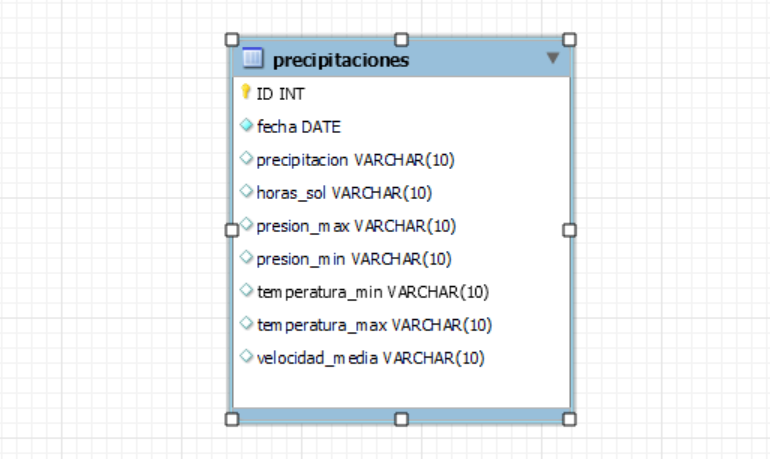


Para ingestar los datos, utilizaré la librería "mysql.connector", como se puede ver a continuación.

In [41]:
# Conection with localhost 
mydb = mysql.connector.connect(
  host='localhost',
  user='root',
  password='c4nionerou', 
  database='bcn_precipitaciones'
)

In [42]:
# Opnening a cursor
mycursor = mydb.cursor()

In [43]:
# Query for ingesting
query = '''INSERT INTO precipitaciones
           values (%s,%s,%s,%s,%s,%s,%s,%s,%s)'''

In [44]:
# List of lists for ingesting values.
sql_data = DATA.to_numpy().tolist()
sql_data[:31]

[[0, '1992-01-01', '0.0', '6.6', '1037.8', '1033.6', '11.6', '0.3', '7.92'],
 [1, '1992-01-02', '0.0', '6.4', '1038.6', '1037.0', '12.6', '0.2', '11.16'],
 [2, '1992-01-03', '0.3', '1.0', '1037.3', '1032.7', '12.2', '2.3', '7.92'],
 [3, '1992-01-04', '0.0', '5.7', '1034.3', '1031.4', '12.5', '1.3', '11.16'],
 [4, '1992-01-05', '0.0', '6.8', '1034.3', '1032.0', '12.4', '0.2', '11.16'],
 [5, '1992-01-06', '0.0', '6.6', '1032.6', '1029.8', '11.2', '0.1', '18'],
 [6, '1992-01-07', '0.0', '0.0', '1030.8', '1026.1', '10.4', '1.0', '7.92'],
 [7, '1992-01-08', '0.0', '0.0', '1026.1', '1018.2', '13.3', '6.5', '18'],
 [8, '1992-01-09', '1.3', '0.0', '1018.2', '1011.2', '12.8', '8.1', '11.16'],
 [9, '1992-01-10', '0.0', '6.4', '1019.9', '1014.6', '12.9', '2.0', '20.88'],
 [10, '1992-01-11', '0', '4.3', '1023.2', '1019.9', '12.1', '2.4', '5.04'],
 [11, '1992-01-12', '6.4', '0.6', '1022.8', '1018.3', '10.2', '5.4', '15.12'],
 [12, '1992-01-13', '0.0', '4.6', '1028.1', '1022.3', '13.2', '4.9', '11.1

In [45]:
# Ingesting multiple lines
mycursor.executemany(query,sql_data)

In [46]:
mycursor.close()


True

In [47]:
mydb.commit()